In [1]:
import torch
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection

from variational_ib import *
from dataloaders import *

In [2]:
lowPresence = pd.read_csv('./data/lowDiversity/lowDiversityPresenceAbsence.csv')
midPresence = pd.read_csv('./data/midDiversity/midDiversityPresenceAbsence.csv')
highPresence = pd.read_csv('./data/highDiversity/highDiversityPresenceAbsence.csv')

lowRelAbs = pd.read_csv('./data/lowDiversity/lowDiversityRelativeAbds.csv')
midRelAbs = pd.read_csv('./data/midDiversity/midDiversityRelativeAbds.csv')
highRelAbs = pd.read_csv('./data/highDiversity/highDiversityRelativeAbds.csv')

trainLowPresence, testLowPresence, trainLowRelAbs, testLowRelAbs = sklearn.model_selection.train_test_split(lowPresence, lowRelAbs)
trainMidPresence, testMidPresence, trainMidRelAbs, testMidRelAbs = sklearn.model_selection.train_test_split(midPresence, midRelAbs)
trainHighPresence, testHighPresence, trainHighRelAbs, testHighRelAbs = sklearn.model_selection.train_test_split(highPresence, highRelAbs)


In [130]:
trainLowDivDataset = Ecology_Dataset(trainLowPresence, trainLowRelAbs)
testLowDivDataset = Ecology_Dataset(testLowPresence, testLowRelAbs)

trainMidDivDataset = Ecology_Dataset(trainMidPresence, trainMidRelAbs)
testMidDivDataset = Ecology_Dataset(testMidPresence, testMidRelAbs)

trainHighDivDataset = Ecology_Dataset(trainHighPresence, trainHighRelAbs)
testHighDivDataset = Ecology_Dataset(testHighPresence, testHighRelAbs)

LowDivDataset = Ecology_Dataset(lowPresence, lowRelAbs)
MidDivDataset = Ecology_Dataset(midPresence, midRelAbs)
HighDivDataset = Ecology_Dataset(highPresence, highRelAbs)

In [4]:
encoder = Encoder(
    input_dim=trainLowDivDataset.data_dim,
    hidden_dims=[200,200,200],
    latent_dim=3,
    activation=None
)

decoder = Decoder(
    latent_dim=3,
    hidden_dims=[200,200,200],
    output_dim=trainLowDivDataset.data_dim,
    activation=None
)

vib = VariationalIB(encoder, decoder, latent_dim=3, input_dim=trainLowDivDataset.data_dim)


In [131]:
trainLowDivDataLoader = torch.utils.data.DataLoader(trainLowDivDataset, batch_size=32, shuffle = True)
testLowDivDataLoader = torch.utils.data.DataLoader(testLowDivDataset, batch_size=32)

trainMidDivDataLoader = torch.utils.data.DataLoader(trainMidDivDataset, batch_size=32, shuffle = True)
testMidDivDataLoader = torch.utils.data.DataLoader(testMidDivDataset, batch_size=32)

trainHighDivDataLoader = torch.utils.data.DataLoader(trainHighDivDataset, batch_size=32, shuffle = True)
testHighDivDataLoader = torch.utils.data.DataLoader(testHighDivDataset, batch_size=32)

LowDivDataLoader = torch.utils.data.DataLoader(LowDivDataset, batch_size=32)
MidDivDataLoader = torch.utils.data.DataLoader(MidDivDataset, batch_size=32)
HighDivDataLoader = torch.utils.data.DataLoader(HighDivDataset, batch_size=32)

In [203]:
recon_loss_collected = []
prior_loss_collected = []

low_I_XZ_test_low = []
low_I_YZ_test_low = []

low_I_XZ_test_mid = []
low_I_YZ_test_mid = []

low_I_XZ_test_high = []
low_I_YZ_test_high = []

batch_size = 32
latent_dim = 10
max_epochs = 200

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=None
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=None
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainLowDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testLowDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testLowDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_low.append(elbo_loss / len(testLowDivDataset))
    low_I_YZ_test_low.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_mid.append(elbo_loss / len(testMidDivDataset))
    low_I_YZ_test_mid.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testHighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_high.append(elbo_loss / len(testHighDivDataset))
    low_I_YZ_test_high.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:08<14:09,  8.50s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:17<14:30,  8.79s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:26<14:14,  8.72s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:34<13:52,  8.58s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [00:43<13:53,  8.68s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [00:52<14:11,  8.97s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [01:02<14:14,  9.09s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [01:11<14:03,  9.07s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [01:20<13:47,  8.99s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [01:29<13:39,  9.00s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [01:38<13:38,  9.10s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [01:48<13:53,  9.36s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [01:58<13:56,  9.50s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [02:07<13:48,  9.52s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [02:17<13:33,  9.46s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [02:26<13:27,  9.50s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [02:36<13:18,  9.51s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [02:46<13:26,  9.72s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [02:55<13:02,  9.54s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [03:05<13:04,  9.69s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [03:15<13:00,  9.76s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [03:24<12:39,  9.62s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [03:34<12:26,  9.57s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [03:44<12:22,  9.64s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [03:53<12:11,  9.63s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [04:02<11:52,  9.50s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [04:12<11:41,  9.48s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [04:22<11:39,  9.58s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [04:31<11:28,  9.56s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [04:41<11:19,  9.56s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [04:50<11:10,  9.58s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [05:00<10:58,  9.55s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [05:10<10:54,  9.63s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [05:19<10:47,  9.67s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [05:29<10:44,  9.77s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [05:39<10:25,  9.63s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [05:48<10:19,  9.68s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [05:58<10:12,  9.72s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [06:08<10:04,  9.75s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [06:17<09:45,  9.60s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [06:27<09:36,  9.62s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [06:37<09:33,  9.72s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [06:47<09:29,  9.82s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [06:57<09:22,  9.86s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [07:07<09:14,  9.90s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [07:17<09:00,  9.84s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [07:26<08:50,  9.83s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [07:36<08:37,  9.77s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [07:46<08:35,  9.91s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [07:56<08:18,  9.76s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [08:05<08:03,  9.66s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [08:15<07:56,  9.73s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [08:24<07:41,  9.62s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [08:34<07:30,  9.59s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [08:43<07:19,  9.55s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [08:53<07:15,  9.67s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [09:03<07:03,  9.63s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [09:12<06:52,  9.59s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [09:22<06:45,  9.65s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [09:32<06:36,  9.67s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [09:42<06:33,  9.85s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [09:52<06:22,  9.81s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [10:02<06:21, 10.04s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [10:12<06:08,  9.96s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [10:22<06:01, 10.03s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [10:32<05:48,  9.96s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [10:42<05:37,  9.93s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [10:52<05:27,  9.92s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [11:02<05:19,  9.98s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [11:13<05:14, 10.15s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [11:23<05:07, 10.24s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [11:33<04:57, 10.27s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [11:44<04:46, 10.23s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [11:53<04:33, 10.13s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [12:04<04:23, 10.13s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [12:14<04:16, 10.27s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [12:24<04:05, 10.22s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [12:34<03:52, 10.09s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [12:45<03:44, 10.21s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [12:54<03:31, 10.07s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [13:05<03:23, 10.19s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [13:15<03:14, 10.22s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [13:25<03:02, 10.15s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [13:35<02:52, 10.16s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [13:45<02:43, 10.19s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [13:55<02:31, 10.09s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [14:05<02:20, 10.05s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [14:15<02:09,  9.95s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [14:25<01:58,  9.91s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [14:35<01:50, 10.01s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [14:46<01:41, 10.16s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [14:56<01:31, 10.21s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [15:07<01:22, 10.33s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [15:17<01:12, 10.41s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [15:28<01:02, 10.47s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [15:38<00:52, 10.41s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [15:48<00:40, 10.23s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [15:58<00:30, 10.20s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [16:08<00:20, 10.05s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [16:17<00:09,  9.94s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [16:27<00:00,  9.78s/it]

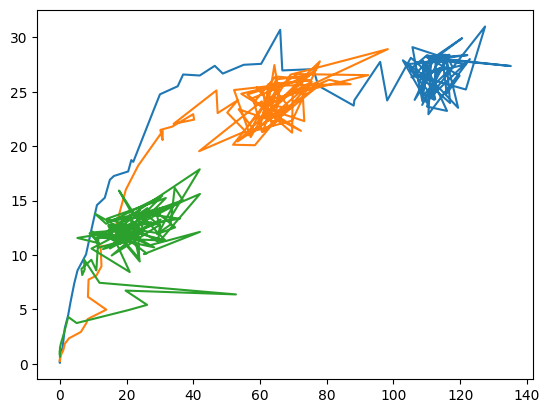

In [204]:
plt.plot(low_I_XZ_test_low, low_I_YZ_test_low, label = "Low diversity data")
plt.plot(low_I_XZ_test_mid, low_I_YZ_test_mid, label = "Mid diversity data")
plt.plot(low_I_XZ_test_high, low_I_YZ_test_high, label = "High diversity data")


In [205]:
recon_loss_collected = []
prior_loss_collected = []

mid_I_XZ_test_low = []
mid_I_YZ_test_low = []

mid_I_XZ_test_mid = []
mid_I_YZ_test_mid = []

mid_I_XZ_test_high = []
mid_I_YZ_test_high = []

batch_size = 32
latent_dim = 10
max_epochs = 200

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=None
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=None
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainMidDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testMidDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testLowDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_low.append(elbo_loss / len(testLowDivDataset))
    mid_I_YZ_test_low.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_mid.append(elbo_loss / len(testMidDivDataset))
    mid_I_YZ_test_mid.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testHighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_high.append(elbo_loss / len(testHighDivDataset))
    mid_I_YZ_test_high.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:05<08:33,  5.13s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:10<08:26,  5.12s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:15<08:30,  5.21s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:21<08:39,  5.36s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [00:26<08:28,  5.30s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [00:31<08:23,  5.30s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [00:37<08:25,  5.38s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [00:42<08:26,  5.45s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [00:48<08:16,  5.39s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [00:53<08:11,  5.40s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [00:58<08:05,  5.40s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [01:04<07:54,  5.33s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [01:09<07:48,  5.32s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [01:14<07:45,  5.35s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [01:20<07:44,  5.41s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [01:25<07:38,  5.39s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [01:31<07:36,  5.43s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [01:36<07:31,  5.44s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [01:42<07:35,  5.56s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [01:47<07:27,  5.53s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [01:53<07:19,  5.50s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [01:58<07:12,  5.48s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [02:05<07:25,  5.72s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [02:10<07:16,  5.67s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [02:16<07:08,  5.64s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [02:21<07:01,  5.62s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [02:27<06:55,  5.62s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [02:33<06:54,  5.68s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [02:39<06:52,  5.73s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [02:44<06:50,  5.79s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [02:50<06:41,  5.74s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [02:56<06:35,  5.73s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [03:01<06:26,  5.69s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [03:07<06:16,  5.62s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [03:12<06:10,  5.62s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [03:18<06:08,  5.67s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [03:24<06:03,  5.67s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [03:30<05:56,  5.66s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [03:35<05:54,  5.72s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [03:41<05:47,  5.70s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [03:47<05:46,  5.77s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [03:53<05:37,  5.72s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [03:58<05:29,  5.68s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [04:04<05:28,  5.76s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [04:10<05:21,  5.73s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [04:16<05:15,  5.74s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [04:21<05:09,  5.73s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [04:27<05:02,  5.71s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [04:33<04:55,  5.68s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [04:38<04:51,  5.72s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [04:44<04:42,  5.65s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [04:49<04:34,  5.61s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [04:55<04:31,  5.65s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [05:01<04:25,  5.64s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [05:07<04:24,  5.74s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [05:12<04:15,  5.67s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [05:18<04:10,  5.69s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [05:24<04:02,  5.64s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [05:29<03:58,  5.68s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [05:35<03:53,  5.70s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [05:41<03:48,  5.70s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [05:46<03:41,  5.67s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [05:52<03:36,  5.71s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [05:58<03:32,  5.74s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [06:04<03:28,  5.80s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [06:10<03:24,  5.85s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [06:16<03:17,  5.81s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [06:21<03:10,  5.76s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [06:27<03:05,  5.79s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [06:33<03:00,  5.83s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [06:39<02:56,  5.88s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [06:45<02:48,  5.81s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [06:51<02:44,  5.86s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [06:57<02:39,  5.90s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [07:02<02:31,  5.84s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [07:08<02:27,  5.88s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [07:14<02:22,  5.92s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [07:20<02:17,  5.98s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [07:26<02:09,  5.87s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [07:32<02:04,  5.91s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [07:38<01:56,  5.84s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [07:44<01:51,  5.86s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [07:50<01:46,  5.90s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [07:55<01:39,  5.86s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [08:02<01:35,  5.95s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [08:07<01:27,  5.86s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [08:14<01:24,  6.03s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [08:20<01:18,  6.02s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [08:26<01:11,  5.98s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [08:31<01:05,  5.93s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [08:37<00:58,  5.87s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [08:43<00:52,  5.84s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [08:49<00:46,  5.80s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [08:54<00:40,  5.82s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [09:00<00:35,  5.86s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [09:06<00:28,  5.80s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [09:12<00:22,  5.75s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [09:17<00:17,  5.75s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [09:23<00:11,  5.72s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [09:29<00:05,  5.73s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [09:35<00:00,  5.70s/it]

Text(0.5, 1.0, 'Models trained on Mid Diversity Data')

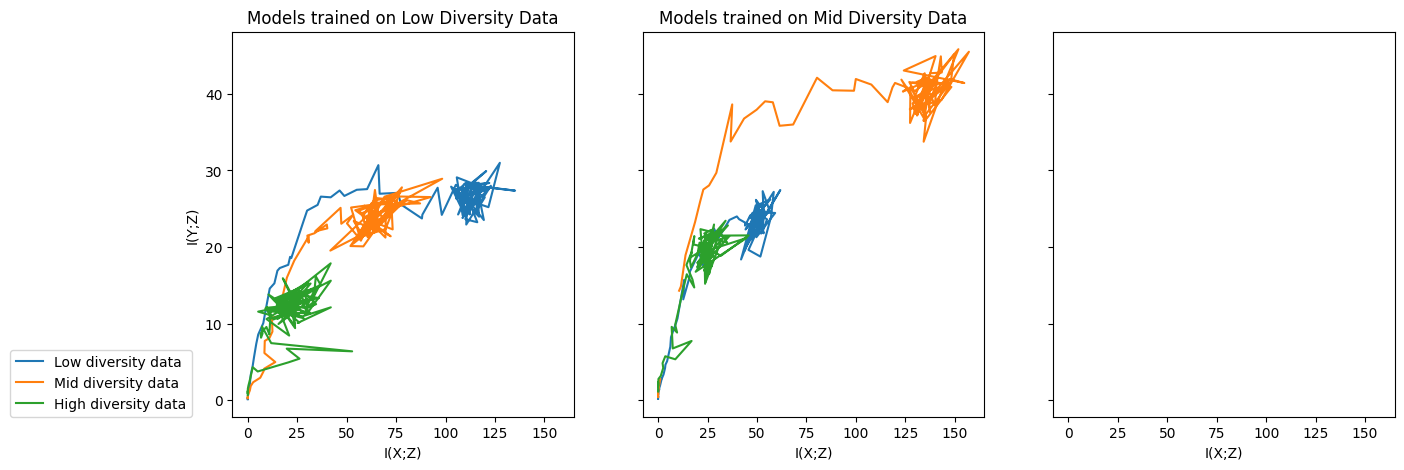

In [206]:
fig, axs = plt.subplots(1, 3, sharex = True, sharey = True)
fig.set_size_inches(15,5)

axs[0].set_ylabel('I(Y;Z)')
axs[0].set_xlabel('I(X;Z)')
axs[1].set_xlabel('I(X;Z)')
axs[2].set_xlabel('I(X;Z)')


axs[0].plot(low_I_XZ_test_low, low_I_YZ_test_low, label = "Low diversity data")
axs[0].plot(low_I_XZ_test_mid, low_I_YZ_test_mid, label = "Mid diversity data")
axs[0].plot(low_I_XZ_test_high, low_I_YZ_test_high, label = "High diversity data")
axs[0].set_title('Models trained on Low Diversity Data')

axs[0].legend(loc=(-.65, 0))

axs[1].plot(mid_I_XZ_test_low, mid_I_YZ_test_low, label = "Low diversity data")
axs[1].plot(mid_I_XZ_test_mid, mid_I_YZ_test_mid, label = "Mid diversity data")
axs[1].plot(mid_I_XZ_test_high, mid_I_YZ_test_high, label = "High diversity data")
axs[1].set_title('Models trained on Mid Diversity Data')

In [207]:
recon_loss_collected = []
prior_loss_collected = []

high_I_XZ_test_low = []
high_I_YZ_test_low = []

high_I_XZ_test_mid = []
high_I_YZ_test_mid = []

high_I_XZ_test_high = []
high_I_YZ_test_high = []

batch_size = 32
latent_dim = 10
max_epochs = 200

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=None
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=None
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainHighDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testHighDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testLowDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_low.append(elbo_loss / len(testLowDivDataset))
    high_I_YZ_test_low.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_mid.append(elbo_loss / len(testMidDivDataset))
    high_I_YZ_test_mid.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testHighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_high.append(elbo_loss / len(testHighDivDataset))
    high_I_YZ_test_high.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:02<03:51,  2.31s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:04<04:10,  2.53s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:07<03:58,  2.44s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:09<03:47,  2.35s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [00:11<03:41,  2.31s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [00:14<03:41,  2.33s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [00:16<03:36,  2.30s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [00:18<03:31,  2.27s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [00:20<03:27,  2.25s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [00:23<03:27,  2.28s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [00:25<03:23,  2.27s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [00:27<03:19,  2.25s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [00:29<03:16,  2.23s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [00:31<03:11,  2.20s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [00:33<03:06,  2.17s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [00:36<03:03,  2.16s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [00:38<03:02,  2.17s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [00:40<02:59,  2.17s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [00:42<02:56,  2.15s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [00:44<02:53,  2.15s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [00:46<02:49,  2.11s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [00:48<02:45,  2.10s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [00:50<02:42,  2.08s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [00:52<02:40,  2.08s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [00:54<02:36,  2.06s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [00:57<02:34,  2.06s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [00:59<02:31,  2.04s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [01:01<02:30,  2.06s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [01:03<02:27,  2.05s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [01:05<02:24,  2.03s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [01:07<02:22,  2.04s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [01:09<02:20,  2.03s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [01:11<02:23,  2.11s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [01:13<02:21,  2.11s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [01:15<02:19,  2.11s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [01:17<02:18,  2.12s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [01:19<02:13,  2.09s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [01:22<02:11,  2.09s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [01:24<02:07,  2.06s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [01:26<02:06,  2.08s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [01:28<02:02,  2.05s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [01:30<02:02,  2.08s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [01:32<02:01,  2.09s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [01:34<01:58,  2.08s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [01:36<01:58,  2.11s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [01:38<01:59,  2.16s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [01:41<01:56,  2.16s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [01:43<01:54,  2.15s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [01:45<01:52,  2.16s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [01:47<01:49,  2.14s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [01:49<01:45,  2.12s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [01:51<01:43,  2.11s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [01:53<01:41,  2.12s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [01:55<01:39,  2.11s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [01:57<01:37,  2.12s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [02:00<01:34,  2.11s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [02:02<01:34,  2.16s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [02:04<01:31,  2.12s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [02:06<01:29,  2.12s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [02:08<01:27,  2.13s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [02:10<01:26,  2.15s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [02:12<01:23,  2.13s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [02:15<01:20,  2.13s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [02:17<01:21,  2.21s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [02:19<01:19,  2.21s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [02:21<01:15,  2.16s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [02:23<01:12,  2.13s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [02:25<01:09,  2.11s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [02:27<01:07,  2.12s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [02:30<01:07,  2.19s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [02:32<01:06,  2.22s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [02:34<01:03,  2.20s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [02:36<01:01,  2.19s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [02:39<01:01,  2.29s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [02:41<00:58,  2.24s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [02:43<00:56,  2.25s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [02:45<00:52,  2.19s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [02:48<00:50,  2.18s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [02:50<00:47,  2.17s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [02:52<00:45,  2.17s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [02:54<00:42,  2.14s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [02:56<00:40,  2.13s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [02:58<00:39,  2.20s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [03:01<00:38,  2.25s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [03:03<00:35,  2.20s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [03:05<00:33,  2.20s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [03:07<00:30,  2.17s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [03:09<00:28,  2.19s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [03:12<00:26,  2.18s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [03:14<00:24,  2.19s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [03:16<00:21,  2.16s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [03:18<00:19,  2.17s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [03:20<00:17,  2.16s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [03:22<00:15,  2.16s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [03:24<00:12,  2.15s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [03:27<00:11,  2.24s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [03:29<00:08,  2.19s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [03:31<00:06,  2.20s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [03:33<00:04,  2.18s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [03:35<00:02,  2.15s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:38<00:00,  2.16s/it]

Text(0.5, 1.0, 'Models trained on High Diversity Data')

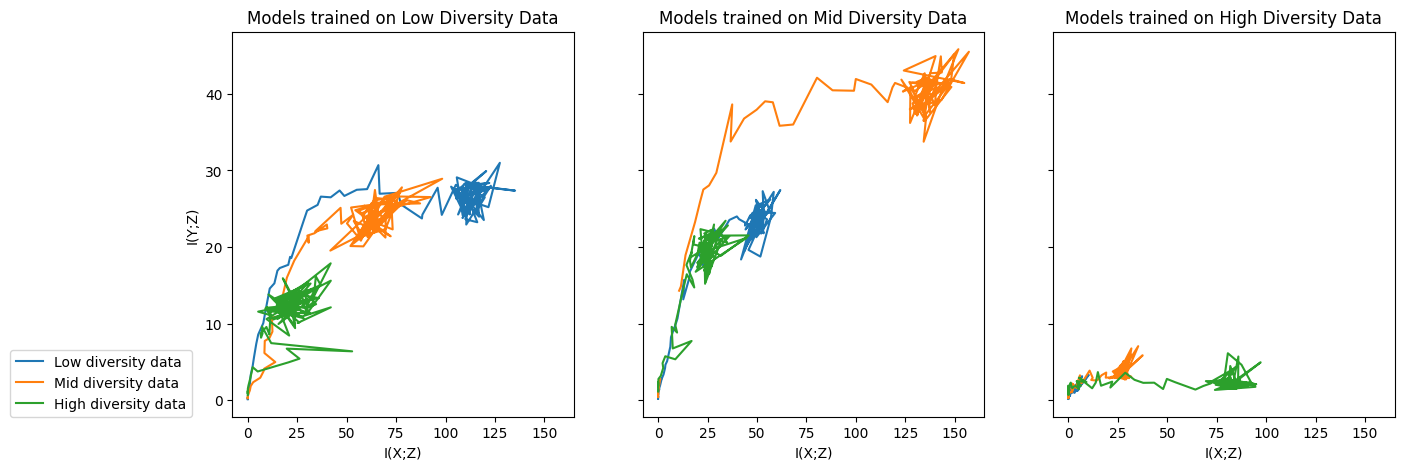

In [208]:
fig, axs = plt.subplots(1, 3, sharex = True, sharey = True)
fig.set_size_inches(15,5)

axs[0].set_ylabel('I(Y;Z)')
axs[0].set_xlabel('I(X;Z)')
axs[1].set_xlabel('I(X;Z)')
axs[2].set_xlabel('I(X;Z)')


axs[0].plot(low_I_XZ_test_low, low_I_YZ_test_low, label = "Low diversity data")
axs[0].plot(low_I_XZ_test_mid, low_I_YZ_test_mid, label = "Mid diversity data")
axs[0].plot(low_I_XZ_test_high, low_I_YZ_test_high, label = "High diversity data")
axs[0].set_title('Models trained on Low Diversity Data')

axs[0].legend(loc=(-.65, 0))

axs[1].plot(mid_I_XZ_test_low, mid_I_YZ_test_low, label = "Low diversity data")
axs[1].plot(mid_I_XZ_test_mid, mid_I_YZ_test_mid, label = "Mid diversity data")
axs[1].plot(mid_I_XZ_test_high, mid_I_YZ_test_high, label = "High diversity data")
axs[1].set_title('Models trained on Mid Diversity Data')

axs[2].plot(high_I_XZ_test_low, high_I_YZ_test_low, label = "Low diversity data")
axs[2].plot(high_I_XZ_test_mid, high_I_YZ_test_mid, label = "Mid diversity data")
axs[2].plot(high_I_XZ_test_high, high_I_YZ_test_high, label = "High diversity data")
axs[2].set_title('Models trained on High Diversity Data')

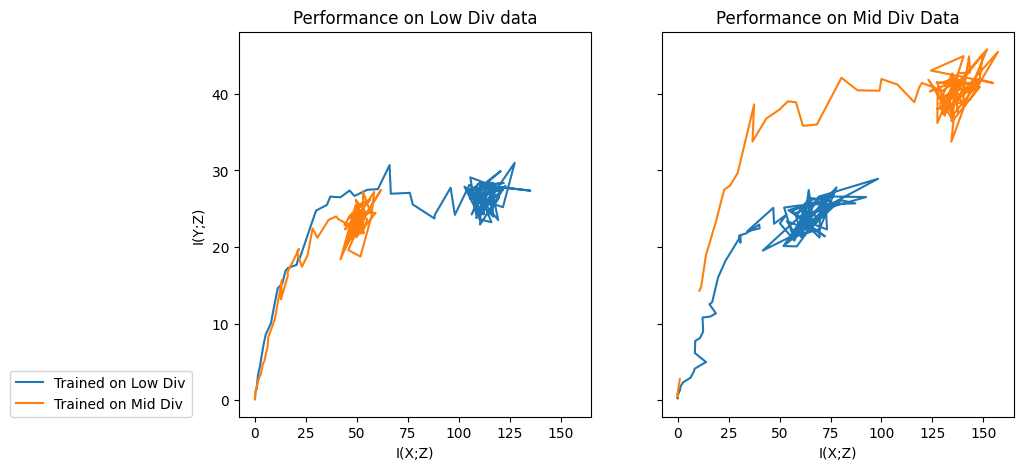

In [210]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True)
fig.set_size_inches(10,5)



axs[0].set_ylabel('I(Y;Z)')
axs[0].set_xlabel('I(X;Z)')
axs[1].set_xlabel('I(X;Z)')

axs[0].set_title('Performance on Low Div data')
axs[0].plot(low_I_XZ_test_low, low_I_YZ_test_low, label = 'Trained on Low Div')
axs[0].plot(mid_I_XZ_test_low, mid_I_YZ_test_low, label = 'Trained on Mid Div')

axs[1].set_title('Performance on Mid Div Data')
axs[1].plot(low_I_XZ_test_mid, low_I_YZ_test_mid, label = 'Trained on Low Div')
axs[1].plot(mid_I_XZ_test_mid, mid_I_YZ_test_mid, label = 'Trained on Mid Div')

axs[0].legend(loc = (-0.65,0))

In [219]:
recon_loss_collected = []
prior_loss_collected = []

low_I_XZ_test_low_nonlinear = []
low_I_YZ_test_low_nonlinear = []

low_I_XZ_test_mid_nonlinear = []
low_I_YZ_test_mid_nonlinear = []

low_I_XZ_test_high_nonlinear = []
low_I_YZ_test_high_nonlinear = []

batch_size = 32
latent_dim = 10
max_epochs = 300

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=torch.nn.ReLU()
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=torch.nn.ReLU()
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainLowDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testLowDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testLowDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_low_nonlinear.append(elbo_loss / len(testLowDivDataset))
    low_I_YZ_test_low_nonlinear.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_mid_nonlinear.append(elbo_loss / len(testMidDivDataset))
    low_I_YZ_test_mid_nonlinear.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testHighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_high_nonlinear.append(elbo_loss / len(testHighDivDataset))
    low_I_YZ_test_high_nonlinear.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:12<21:39, 13.00s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:26<21:43, 13.17s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:40<22:07, 13.55s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:53<21:58, 13.59s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [01:07<21:51, 13.66s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [01:22<22:13, 14.04s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [01:36<22:04, 14.09s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [01:51<21:56, 14.16s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [02:05<21:43, 14.16s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [02:19<21:27, 14.15s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [02:33<21:18, 14.21s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [02:48<21:33, 14.53s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [03:03<21:07, 14.40s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [03:17<20:48, 14.35s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [03:31<20:43, 14.46s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [03:46<20:21, 14.37s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [04:00<20:08, 14.39s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [04:15<19:56, 14.41s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [04:29<19:53, 14.55s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [04:44<19:49, 14.69s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [04:58<19:20, 14.51s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [05:13<19:14, 14.61s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [05:28<18:57, 14.59s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [05:42<18:30, 14.43s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [05:56<18:08, 14.32s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [06:10<17:50, 14.27s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [06:25<17:38, 14.30s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [06:39<17:21, 14.26s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [06:53<17:03, 14.21s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [07:07<16:48, 14.20s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [07:22<16:47, 14.39s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [07:36<16:36, 14.44s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [07:51<16:17, 14.37s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [08:05<16:07, 14.44s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [08:20<15:55, 14.48s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [08:35<15:59, 14.76s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [08:50<15:42, 14.72s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [09:04<15:20, 14.61s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [09:19<15:04, 14.60s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [09:33<14:46, 14.53s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [09:48<14:32, 14.54s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [10:02<14:19, 14.56s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [10:16<13:58, 14.46s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [10:31<13:45, 14.49s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [10:45<13:31, 14.48s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [11:00<13:14, 14.45s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [11:15<13:06, 14.57s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [11:29<12:48, 14.49s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [11:44<12:39, 14.61s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [11:58<12:21, 14.55s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [12:13<12:03, 14.48s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [12:28<12:01, 14.72s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [12:42<11:39, 14.57s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [12:56<11:20, 14.47s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [13:11<11:05, 14.47s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [13:25<10:49, 14.44s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [13:40<10:37, 14.49s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [13:54<10:20, 14.43s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [14:09<10:09, 14.52s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [14:24<09:59, 14.63s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [14:38<09:45, 14.63s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [14:53<09:33, 14.71s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [15:08<09:19, 14.72s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [15:23<09:10, 14.87s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [15:38<08:58, 14.96s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [15:54<08:48, 15.09s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [16:10<08:41, 15.34s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [16:25<08:22, 15.23s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [16:40<08:03, 15.12s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [16:55<07:47, 15.08s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [17:10<07:31, 15.06s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [17:25<07:19, 15.16s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [17:40<07:02, 15.08s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [17:54<06:42, 14.90s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [18:09<06:23, 14.77s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [18:25<06:18, 15.14s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [18:40<06:03, 15.16s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [18:55<05:49, 15.21s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [19:10<05:31, 15.07s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [19:25<05:14, 14.97s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [19:40<05:01, 15.07s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [19:56<04:50, 15.29s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [20:11<04:34, 15.27s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [20:26<04:17, 15.17s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [20:41<04:02, 15.14s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [20:56<03:45, 15.01s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [21:11<03:29, 14.98s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [21:26<03:17, 15.17s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [21:42<03:04, 15.35s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [21:58<02:49, 15.41s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [22:13<02:34, 15.41s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [22:28<02:17, 15.28s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [22:43<02:02, 15.32s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [22:59<01:47, 15.29s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [23:14<01:31, 15.27s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [23:30<01:17, 15.48s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [23:47<01:03, 15.90s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [24:03<00:47, 15.88s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [24:18<00:31, 15.81s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [24:34<00:15, 15.83s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [24:49<00:00, 14.75s/it]

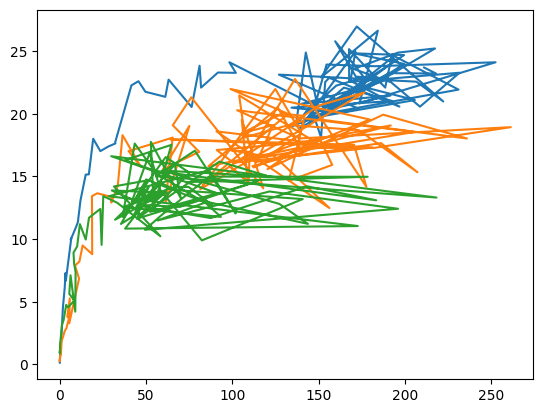

In [212]:
plt.plot(low_I_XZ_test_low_nonlinear, low_I_YZ_test_low_nonlinear, label = "Low diversity data")
plt.plot(low_I_XZ_test_mid_nonlinear, low_I_YZ_test_mid_nonlinear, label = "Mid diversity data")
plt.plot(low_I_XZ_test_high_nonlinear, low_I_YZ_test_high_nonlinear, label = "High diversity data")


In [294]:
recon_loss_collected = []
prior_loss_collected = []

mid_I_XZ_test_low_nonlinear = []
mid_I_YZ_test_low_nonlinear = []

mid_I_XZ_test_mid_nonlinear = []
mid_I_YZ_test_mid_nonlinear = []

mid_I_XZ_test_high_nonlinear = []
mid_I_YZ_test_high_nonlinear = []

batch_size = 32
latent_dim = 10
max_epochs = 350

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[300,300,300],
        latent_dim=latent_dim,
        activation=torch.nn.ReLU()
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[300,300,300],
        output_dim=trainLowDivDataset.data_dim,
        activation=torch.nn.ReLU()
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainLowDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testMidDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_low_nonlinear.append(elbo_loss / len(testLowDivDataset))
    mid_I_YZ_test_low_nonlinear.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_mid_nonlinear.append(elbo_loss / len(testMidDivDataset))
    mid_I_YZ_test_mid_nonlinear.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testHighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_high_nonlinear.append(elbo_loss / len(testHighDivDataset))
    mid_I_YZ_test_high_nonlinear.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:16<27:50, 16.71s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:32<26:36, 16.13s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:48<26:27, 16.20s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [01:04<25:56, 16.05s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [01:21<26:09, 16.35s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [01:37<25:52, 16.35s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [01:54<25:48, 16.47s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [02:11<25:40, 16.57s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [02:28<25:40, 16.74s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [02:45<25:40, 16.92s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [03:02<25:29, 16.99s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [03:20<25:40, 17.31s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [03:38<25:25, 17.33s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [03:55<25:06, 17.32s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [04:12<24:43, 17.25s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [04:29<24:24, 17.23s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [04:47<24:17, 17.35s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [05:05<24:05, 17.42s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [05:22<23:41, 17.34s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [05:40<23:36, 17.49s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [05:57<23:25, 17.57s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [06:15<23:10, 17.60s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [06:33<23:09, 17.82s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [06:51<22:52, 17.83s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [07:10<22:49, 18.01s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [07:28<22:29, 17.99s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [07:45<22:03, 17.89s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [08:03<21:40, 17.81s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [08:21<21:40, 18.07s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [08:39<21:21, 18.06s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [08:57<20:59, 17.99s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [09:15<20:37, 17.94s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [09:32<20:07, 17.75s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [09:51<20:08, 18.03s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [10:09<19:44, 17.94s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [10:26<19:19, 17.84s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [10:45<19:21, 18.14s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [11:03<18:45, 17.86s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [11:20<18:14, 17.65s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [11:37<17:45, 17.47s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [11:56<17:59, 17.98s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [12:14<17:47, 18.10s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [12:32<17:15, 17.86s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [12:49<16:43, 17.61s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [13:06<16:23, 17.56s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [13:24<16:09, 17.64s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [13:41<15:41, 17.43s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [13:59<15:29, 17.53s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [14:16<15:08, 17.47s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [14:33<14:49, 17.43s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [14:51<14:28, 17.37s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [15:09<14:20, 17.57s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [15:27<14:13, 17.78s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [15:45<13:55, 17.78s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [16:02<13:38, 17.80s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [16:20<13:23, 17.86s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [16:39<13:11, 17.98s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [16:58<13:05, 18.28s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [17:17<12:58, 18.54s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [17:36<12:46, 18.70s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [17:55<12:28, 18.72s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [18:12<11:57, 18.41s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [18:30<11:35, 18.29s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [18:48<11:06, 18.02s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [19:05<10:43, 17.87s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [19:23<10:27, 17.93s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [19:41<10:10, 17.96s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [19:59<09:45, 17.75s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [20:16<09:28, 17.77s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [20:34<09:08, 17.71s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [20:52<08:56, 17.87s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [21:11<08:41, 18.00s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [21:28<08:21, 17.92s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [21:46<07:59, 17.78s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [22:04<07:42, 17.79s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [22:21<07:22, 17.70s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [22:39<07:06, 17.78s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [22:57<06:48, 17.77s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [23:14<06:30, 17.75s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [23:32<06:12, 17.74s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [23:50<05:53, 17.68s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [24:08<05:40, 17.92s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [24:27<05:27, 18.19s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [24:46<05:11, 18.32s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [25:05<04:59, 18.73s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [25:24<04:40, 18.71s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [25:42<04:18, 18.47s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [26:00<03:59, 18.45s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [26:18<03:39, 18.27s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [26:36<03:20, 18.27s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [26:55<03:03, 18.32s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [27:13<02:43, 18.18s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [27:31<02:25, 18.14s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [27:48<02:05, 17.98s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [28:06<01:47, 17.89s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [28:24<01:29, 17.90s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [28:42<01:11, 17.94s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [29:00<00:53, 17.88s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [29:18<00:35, 17.92s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [29:35<00:17, 17.83s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [29:54<00:00, 17.77s/it]

In [287]:
len(val_losses[1e-10])

350

In [297]:
mid_I_YZ_test_mid_nonlinear

[tensor(-inf),
 tensor(-inf),
 tensor(33.0090),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(30.8608),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 tensor(-inf),
 ten

Text(0.5, 1.0, 'Models trained on Mid Diversity Data')

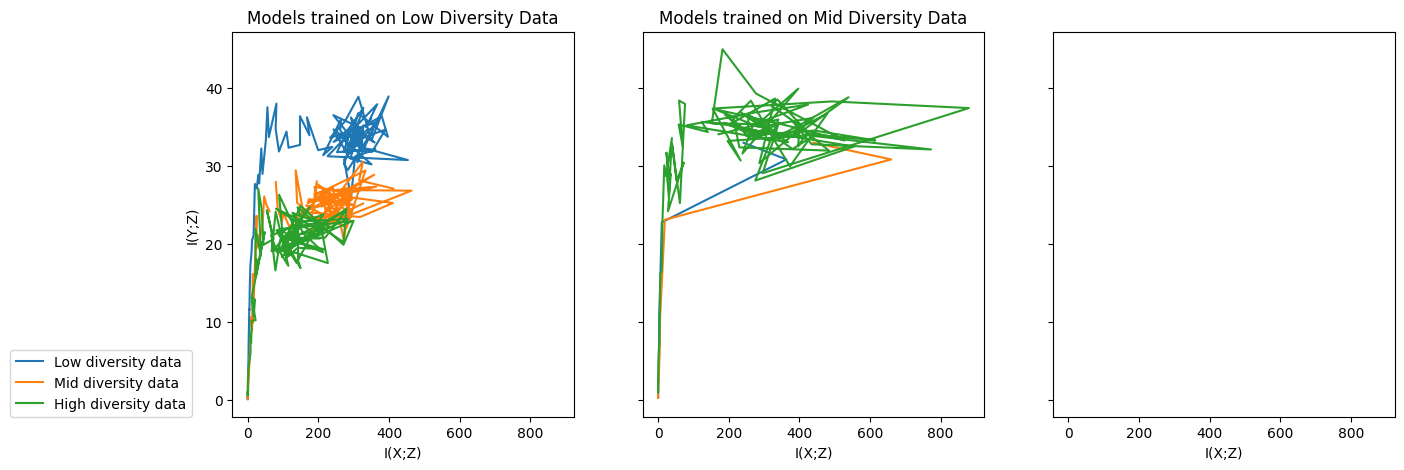

In [298]:
fig, axs = plt.subplots(1, 3, sharex = True, sharey = True)
fig.set_size_inches(15,5)

axs[0].set_ylabel('I(Y;Z)')
axs[0].set_xlabel('I(X;Z)')
axs[1].set_xlabel('I(X;Z)')
axs[2].set_xlabel('I(X;Z)')

mid_I_XZ_test_low_nonlinear = np.asarray(mid_I_XZ_test_low_nonlinear)
mid_I_YZ_test_low_nonlinear = np.asarray(mid_I_YZ_test_low_nonlinear)

mid_I_XZ_test_low_nonlinear = mid_I_XZ_test_low_nonlinear[mid_I_YZ_test_low_nonlinear > - np.inf]
mid_I_YZ_test_low_nonlinear = mid_I_YZ_test_low_nonlinear[mid_I_YZ_test_low_nonlinear > - np.inf]

mid_I_XZ_test_mid_nonlinear = np.asarray(mid_I_XZ_test_mid_nonlinear)
mid_I_YZ_test_mid_nonlinear = np.asarray(mid_I_YZ_test_mid_nonlinear)

mid_I_XZ_test_mid_nonlinear = mid_I_XZ_test_mid_nonlinear[mid_I_YZ_test_mid_nonlinear > - np.inf]
mid_I_YZ_test_mid_nonlinear = mid_I_YZ_test_mid_nonlinear[mid_I_YZ_test_mid_nonlinear > - np.inf]



axs[0].plot(low_I_XZ_test_low_nonlinear, low_I_YZ_test_low_nonlinear, label = "Low diversity data")
axs[0].plot(low_I_XZ_test_mid_nonlinear, low_I_YZ_test_mid_nonlinear, label = "Mid diversity data")
axs[0].plot(low_I_XZ_test_high_nonlinear, low_I_YZ_test_high_nonlinear, label = "High diversity data")
axs[0].set_title('Models trained on Low Diversity Data')

axs[0].legend(loc=(-.65, 0))

axs[1].plot(mid_I_XZ_test_low_nonlinear, mid_I_YZ_test_low_nonlinear, label = "Low diversity data")
axs[1].plot(mid_I_XZ_test_mid_nonlinear, mid_I_YZ_test_mid_nonlinear, label = "Mid diversity data")
axs[1].plot(mid_I_XZ_test_high_nonlinear, mid_I_YZ_test_high_nonlinear, label = "High diversity data")
axs[1].set_title('Models trained on Mid Diversity Data')

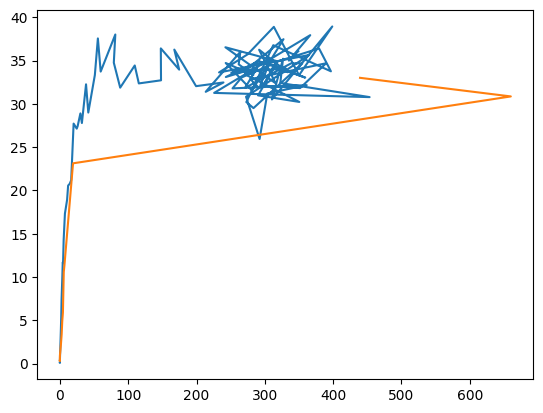

In [299]:
plt.plot(low_I_XZ_test_low_nonlinear, low_I_YZ_test_low_nonlinear)
plt.plot(mid_I_XZ_test_mid_nonlinear, mid_I_YZ_test_mid_nonlinear)


In [215]:
recon_loss_collected = []
prior_loss_collected = []

high_I_XZ_test_low_nonlinear = []
high_I_YZ_test_low_nonlinear = []

high_I_XZ_test_mid_nonlinear = []
high_I_YZ_test_mid_nonlinear = []

high_I_XZ_test_high_nonlinear = []
high_I_YZ_test_high_nonlinear = []

batch_size = 32
latent_dim = 10
max_epochs = 200

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=torch.nn.ReLU()
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=torch.nn.ReLU()
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainHighDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testHighDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_low_nonlinear.append(elbo_loss / len(testLowDivDataset))
    high_I_YZ_test_low_nonlinear.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testMidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_mid_nonlinear.append(elbo_loss / len(testMidDivDataset))
    high_I_YZ_test_mid_nonlinear.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in testHighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-1 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_high_nonlinear.append(elbo_loss / len(testHighDivDataset))
    high_I_YZ_test_high_nonlinear.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:02<03:40,  2.21s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:04<03:32,  2.15s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:06<03:36,  2.21s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:08<03:32,  2.19s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [00:10<03:28,  2.17s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [00:13<03:35,  2.27s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [00:15<03:29,  2.22s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [00:17<03:23,  2.19s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [00:19<03:19,  2.17s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [00:21<03:16,  2.16s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [00:23<03:12,  2.14s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [00:26<03:11,  2.15s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [00:28<03:09,  2.15s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [00:30<03:06,  2.14s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [00:32<03:03,  2.13s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [00:34<03:03,  2.16s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [00:36<03:00,  2.15s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [00:39<02:58,  2.15s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [00:41<02:57,  2.16s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [00:43<03:01,  2.24s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [00:45<02:56,  2.20s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [00:48<02:55,  2.22s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [00:50<02:51,  2.19s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [00:52<02:49,  2.20s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [00:54<02:46,  2.19s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [00:56<02:42,  2.17s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [00:58<02:39,  2.16s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [01:00<02:38,  2.17s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [01:03<02:37,  2.19s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [01:05<02:33,  2.16s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [01:07<02:30,  2.14s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [01:09<02:27,  2.14s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [01:11<02:25,  2.14s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [01:13<02:24,  2.16s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [01:15<02:21,  2.14s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [01:18<02:18,  2.14s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [01:20<02:23,  2.24s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [01:22<02:19,  2.21s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [01:24<02:16,  2.20s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [01:27<02:13,  2.18s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [01:29<02:11,  2.18s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [01:31<02:10,  2.21s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [01:33<02:07,  2.19s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [01:35<02:04,  2.18s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [01:38<02:05,  2.23s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [01:40<02:00,  2.19s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [01:42<01:56,  2.16s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [01:44<01:55,  2.17s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [01:46<01:52,  2.16s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [01:48<01:50,  2.16s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [01:51<01:48,  2.17s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [01:53<01:45,  2.14s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [01:55<01:42,  2.14s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [01:57<01:41,  2.17s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [01:59<01:38,  2.15s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [02:01<01:38,  2.18s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [02:03<01:34,  2.15s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [02:06<01:32,  2.15s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [02:08<01:29,  2.14s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [02:10<01:28,  2.16s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [02:12<01:25,  2.15s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [02:14<01:25,  2.19s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [02:17<01:23,  2.21s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [02:19<01:21,  2.20s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [02:21<01:20,  2.23s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [02:23<01:17,  2.22s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [02:25<01:14,  2.19s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [02:28<01:12,  2.20s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [02:30<01:09,  2.17s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [02:32<01:10,  2.26s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [02:34<01:06,  2.21s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [02:37<01:05,  2.25s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [02:39<01:01,  2.20s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [02:41<00:59,  2.21s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [02:43<00:56,  2.18s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [02:45<00:55,  2.21s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [02:48<00:54,  2.27s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [02:50<00:51,  2.22s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [02:52<00:48,  2.19s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [02:54<00:45,  2.18s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [02:56<00:43,  2.16s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [02:58<00:41,  2.17s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [03:00<00:38,  2.15s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [03:03<00:36,  2.16s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [03:05<00:34,  2.18s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [03:07<00:32,  2.15s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [03:09<00:30,  2.15s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [03:11<00:28,  2.16s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [03:13<00:25,  2.17s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [03:16<00:23,  2.18s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [03:18<00:22,  2.21s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [03:20<00:19,  2.21s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [03:22<00:17,  2.17s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [03:24<00:15,  2.19s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [03:27<00:13,  2.17s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [03:29<00:10,  2.17s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [03:31<00:08,  2.15s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [03:33<00:06,  2.17s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [03:35<00:04,  2.15s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [03:37<00:02,  2.16s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:39<00:00,  2.18s/it]

Text(0.5, 1.0, 'Models trained on High Diversity Data')

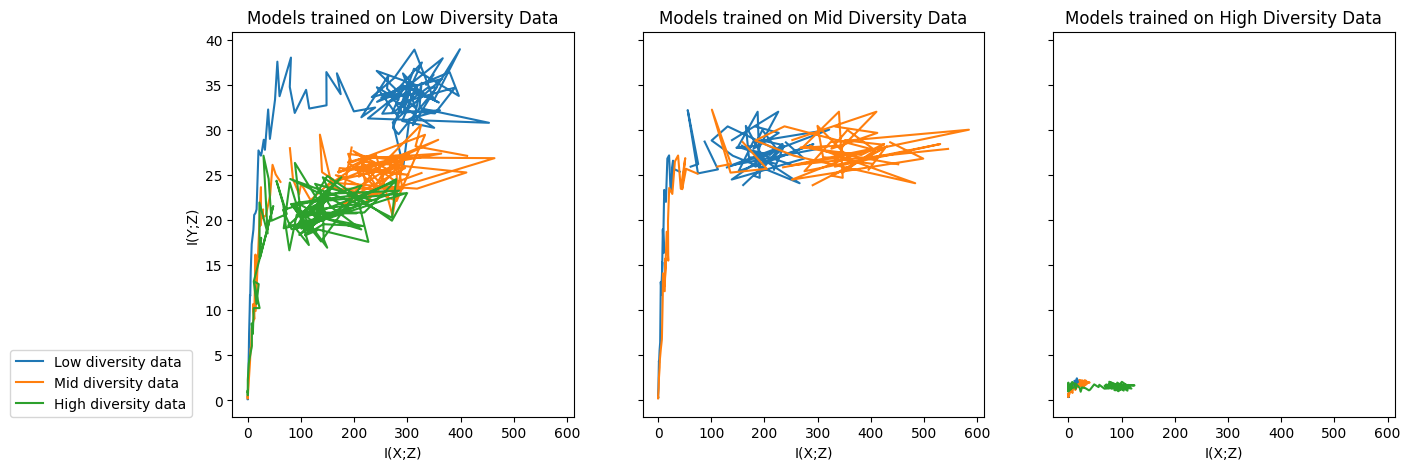

In [291]:
fig, axs = plt.subplots(1, 3, sharex = True, sharey = True)
fig.set_size_inches(15,5)

axs[0].set_ylabel('I(Y;Z)')
axs[0].set_xlabel('I(X;Z)')
axs[1].set_xlabel('I(X;Z)')
axs[2].set_xlabel('I(X;Z)')


axs[0].plot(low_I_XZ_test_low_nonlinear, low_I_YZ_test_low_nonlinear, label = "Low diversity data")
axs[0].plot(low_I_XZ_test_mid_nonlinear, low_I_YZ_test_mid_nonlinear, label = "Mid diversity data")
axs[0].plot(low_I_XZ_test_high_nonlinear, low_I_YZ_test_high_nonlinear, label = "High diversity data")
axs[0].set_title('Models trained on Low Diversity Data')

axs[0].legend(loc=(-.65, 0))

axs[1].plot(mid_I_XZ_test_low_nonlinear, mid_I_YZ_test_low_nonlinear, label = "Low diversity data")
axs[1].plot(mid_I_XZ_test_mid_nonlinear, mid_I_YZ_test_mid_nonlinear, label = "Mid diversity data")
#axs[1].plot(mid_I_XZ_test_high_nonlinear, mid_I_YZ_test_high_nonlinear, label = "High diversity data")
axs[1].set_title('Models trained on Mid Diversity Data')

axs[2].plot(high_I_XZ_test_low_nonlinear, high_I_YZ_test_low_nonlinear, label = "Low diversity data")
axs[2].plot(high_I_XZ_test_mid_nonlinear, high_I_YZ_test_mid_nonlinear, label = "Mid diversity data")
axs[2].plot(high_I_XZ_test_high_nonlinear, high_I_YZ_test_high_nonlinear, label = "High diversity data")
axs[2].set_title('Models trained on High Diversity Data')

In [233]:
mid_I_XZ_test_low_nonlinear

[tensor(451.6130),
 tensor(174.3251),
 tensor(378.9804),
 tensor(448.0935),
 tensor(405.8864),
 tensor(292.6461),
 tensor(344.4741),
 tensor(316.9442),
 tensor(264.6053),
 tensor(443.6559),
 tensor(303.3595),
 tensor(342.2538),
 tensor(185.0686),
 tensor(395.7007),
 tensor(377.7556),
 tensor(393.5408),
 tensor(224.0555),
 tensor(367.2908),
 tensor(302.8107),
 tensor(424.4496),
 tensor(348.6118),
 tensor(442.4012),
 tensor(271.6572),
 tensor(313.0647),
 tensor(211.3120),
 tensor(416.6803),
 tensor(339.1167),
 tensor(433.7607),
 tensor(315.5927),
 tensor(271.5525),
 tensor(216.3475),
 tensor(337.2803),
 tensor(289.2053),
 tensor(332.5855),
 tensor(304.1259),
 tensor(390.6843),
 tensor(268.8853),
 tensor(347.7410),
 tensor(268.9898),
 tensor(514.8905),
 tensor(526.6669),
 tensor(229.5046),
 tensor(289.6263),
 tensor(303.7919),
 tensor(272.0823),
 tensor(336.7880),
 tensor(333.9497),
 tensor(364.8934),
 tensor(304.5888),
 tensor(257.8806),
 tensor(351.8813),
 tensor(258.7802),
 tensor(278.

Text(0.5, 1.0, 'Nonlinear Models trained on Mid Diversity Data')

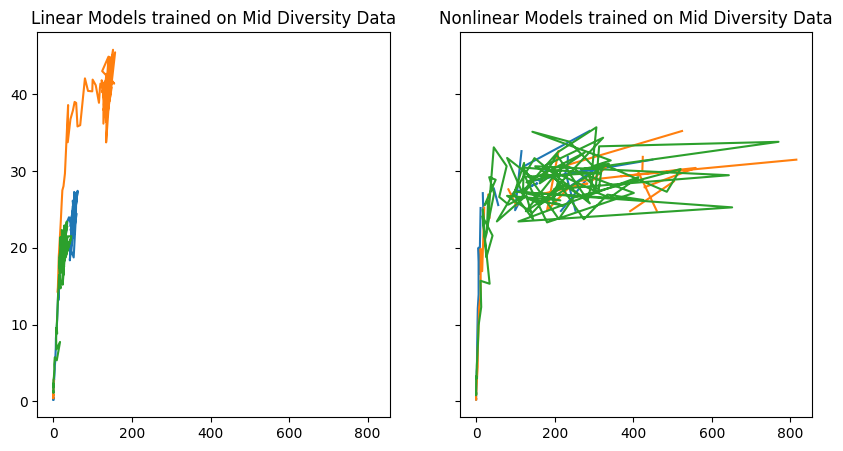

In [226]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True)

fig.set_size_inches(10, 5)
axs[0].plot(mid_I_XZ_test_low, mid_I_YZ_test_low, label = "Low diversity data")
axs[0].plot(mid_I_XZ_test_mid, mid_I_YZ_test_mid, label = "Mid diversity data")
axs[0].plot(mid_I_XZ_test_high, mid_I_YZ_test_high, label = "High diversity data")
axs[0].set_title('Linear Models trained on Mid Diversity Data')

axs[1].plot(mid_I_XZ_test_low_nonlinear, mid_I_YZ_test_low_nonlinear, label = "Low diversity data")
axs[1].plot(mid_I_XZ_test_mid_nonlinear, mid_I_YZ_test_mid_nonlinear, label = "Mid diversity data")
axs[1].plot(mid_I_XZ_test_high_nonlinear, mid_I_YZ_test_high_nonlinear, label = "High diversity data")
axs[1].set_title('Nonlinear Models trained on Mid Diversity Data')


In [199]:
recon_loss_collected = []
prior_loss_collected = []

low_I_XZ_test_low = []
low_I_YZ_test_low = []

low_I_XZ_test_mid = []
low_I_YZ_test_mid = []

low_I_XZ_test_high = []
low_I_YZ_test_high = []

batch_size = 32
latent_dim = 10
max_epochs = 200

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=None
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=None
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainLowDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testLowDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in LowDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 0 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_low.append(elbo_loss / len(LowDivDataset))
    low_I_YZ_test_low.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in MidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov()
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_mid.append(elbo_loss / len(MidDivDataset))
    low_I_YZ_test_mid.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in HighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 0 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_high.append(elbo_loss / len(HighDivDataset))
    low_I_YZ_test_high.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:09<15:00,  9.01s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:18<14:57,  9.07s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:27<14:56,  9.15s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:37<15:27,  9.56s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [00:47<15:20,  9.59s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [00:56<15:03,  9.51s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [01:05<14:44,  9.41s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [01:15<14:35,  9.42s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [01:24<14:16,  9.31s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [01:33<14:07,  9.31s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [01:43<14:09,  9.44s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [01:52<13:51,  9.34s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [02:01<13:45,  9.38s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [02:11<13:33,  9.35s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [02:20<13:27,  9.39s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [02:30<13:32,  9.56s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [02:40<13:23,  9.56s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [02:49<13:09,  9.52s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [02:58<12:56,  9.47s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [03:07<12:33,  9.30s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [03:17<12:23,  9.30s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [03:26<12:17,  9.34s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [03:36<12:12,  9.40s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [03:45<12:12,  9.52s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [03:55<11:56,  9.43s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [04:04<11:40,  9.35s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [04:13<11:33,  9.37s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [04:23<11:30,  9.46s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [04:32<11:18,  9.43s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [04:42<11:14,  9.51s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [04:51<11:02,  9.46s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [05:01<10:52,  9.45s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [05:10<10:33,  9.32s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [05:19<10:27,  9.37s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [05:29<10:19,  9.39s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [05:38<10:15,  9.47s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [05:48<10:02,  9.42s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [05:57<10:01,  9.55s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [06:07<09:49,  9.51s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [06:16<09:34,  9.41s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [06:25<09:21,  9.35s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [06:35<09:10,  9.33s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [06:44<09:03,  9.36s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [06:54<09:00,  9.47s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [07:03<08:50,  9.47s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [07:12<08:35,  9.38s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [07:22<08:23,  9.33s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [07:31<08:15,  9.36s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [07:40<08:05,  9.34s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [07:50<07:55,  9.33s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [07:59<07:50,  9.41s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [08:08<07:38,  9.36s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [08:18<07:33,  9.45s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [08:27<07:21,  9.39s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [08:37<07:09,  9.34s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [08:46<07:07,  9.50s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [08:56<07:01,  9.57s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [09:06<06:57,  9.71s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [09:16<06:42,  9.59s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [09:25<06:30,  9.52s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [09:34<06:19,  9.49s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [09:43<06:05,  9.38s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [09:53<05:59,  9.46s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [10:02<05:47,  9.40s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [10:12<05:38,  9.40s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [10:21<05:26,  9.33s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [10:30<05:18,  9.36s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [10:40<05:09,  9.39s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [10:49<04:58,  9.33s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [10:58<04:46,  9.23s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [11:07<04:39,  9.32s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [11:17<04:28,  9.27s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [11:26<04:20,  9.29s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [11:35<04:10,  9.28s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [11:45<04:01,  9.30s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [11:54<03:54,  9.39s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [12:03<03:44,  9.35s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [12:13<03:36,  9.41s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [12:22<03:24,  9.32s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [12:31<03:14,  9.28s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [12:40<03:05,  9.26s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [12:50<02:55,  9.25s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [12:59<02:48,  9.37s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [13:09<02:38,  9.32s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [13:18<02:29,  9.37s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [13:27<02:19,  9.33s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [13:36<02:09,  9.23s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [13:46<02:00,  9.28s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [13:55<01:51,  9.29s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [14:04<01:41,  9.27s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [14:14<01:34,  9.45s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [14:24<01:25,  9.49s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [14:33<01:15,  9.44s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [14:42<01:05,  9.41s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [14:51<00:55,  9.33s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [15:01<00:46,  9.25s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [15:10<00:37,  9.31s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [15:20<00:28,  9.58s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [15:29<00:18,  9.46s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [15:39<00:09,  9.51s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [15:48<00:00,  9.39s/it]

In [200]:
recon_loss_collected = []
prior_loss_collected = []

mid_I_XZ_test_low = []
mid_I_YZ_test_low = []

mid_I_XZ_test_mid = []
mid_I_YZ_test_mid = []

mid_I_XZ_test_high = []
mid_I_YZ_test_high = []

batch_size = 32
latent_dim = 10
max_epochs = 200

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=None
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=None
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainMidDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testMidDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in LowDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 0 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_low.append(elbo_loss / len(LowDivDataset))
    mid_I_YZ_test_low.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in MidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov()
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_mid.append(elbo_loss / len(MidDivDataset))
    mid_I_YZ_test_mid.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in HighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 0 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    mid_I_XZ_test_high.append(elbo_loss / len(HighDivDataset))
    mid_I_YZ_test_high.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:04<07:52,  4.73s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:09<08:04,  4.89s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:14<07:52,  4.83s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:19<07:41,  4.75s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [00:23<07:31,  4.70s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [00:28<07:34,  4.78s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [00:33<07:32,  4.81s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [00:38<07:35,  4.89s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [00:43<07:26,  4.85s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [00:48<07:17,  4.81s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [00:52<07:09,  4.77s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [00:57<07:06,  4.79s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [01:02<07:06,  4.84s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [01:07<07:02,  4.85s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [01:12<06:55,  4.83s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [01:17<06:55,  4.89s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [01:22<06:50,  4.89s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [01:27<06:45,  4.88s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [01:31<06:42,  4.90s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [01:37<06:42,  4.97s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [01:42<06:39,  4.99s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [01:47<06:42,  5.10s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [01:52<06:37,  5.10s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [01:57<06:28,  5.04s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [02:02<06:24,  5.06s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [02:07<06:16,  5.02s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [02:12<06:14,  5.06s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [02:17<06:12,  5.11s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [02:23<06:13,  5.18s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [02:28<06:14,  5.27s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [03:59<35:56, 30.80s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [04:04<26:39, 23.17s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [04:09<20:07, 17.76s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [04:14<15:30, 13.89s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [04:19<12:19, 11.20s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [04:24<10:03,  9.29s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [04:29<08:37,  8.09s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [04:34<07:29,  7.13s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [04:39<06:43,  6.51s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [04:44<06:08,  6.04s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [04:49<05:48,  5.81s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [04:54<05:26,  5.54s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [04:59<05:08,  5.32s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [05:04<04:55,  5.18s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [05:09<04:47,  5.14s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [05:14<04:42,  5.15s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [05:19<04:44,  5.26s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [05:25<04:37,  5.23s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [05:30<04:29,  5.18s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [05:35<04:24,  5.19s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [05:40<04:22,  5.24s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [05:45<04:12,  5.16s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [05:50<04:06,  5.13s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [05:55<04:00,  5.13s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [06:00<03:53,  5.07s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [06:05<03:48,  5.09s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [06:10<03:42,  5.05s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [06:16<03:42,  5.18s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [06:21<03:40,  5.26s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [06:27<03:41,  5.39s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [06:32<03:34,  5.37s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [06:38<03:26,  5.31s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [06:43<03:20,  5.28s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [06:48<03:13,  5.23s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [06:53<03:09,  5.28s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [06:59<03:07,  5.34s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [07:04<02:59,  5.28s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [07:09<02:52,  5.22s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [07:14<02:47,  5.23s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [07:19<02:41,  5.21s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [07:25<02:36,  5.21s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [07:30<02:32,  5.27s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [07:35<02:27,  5.29s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [07:41<02:21,  5.25s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [07:46<02:16,  5.25s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [07:51<02:09,  5.18s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [07:56<02:04,  5.19s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [08:01<01:58,  5.17s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [08:06<01:54,  5.22s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [08:12<01:52,  5.35s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [08:17<01:46,  5.31s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [08:23<01:42,  5.39s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [08:28<01:37,  5.44s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [08:34<01:31,  5.37s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [08:39<01:26,  5.40s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [08:45<01:21,  5.45s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [08:50<01:17,  5.51s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [08:56<01:11,  5.47s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [09:01<01:04,  5.41s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [09:06<00:59,  5.37s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [09:12<00:53,  5.33s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [09:17<00:47,  5.28s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [09:22<00:42,  5.28s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [09:27<00:37,  5.31s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [09:33<00:31,  5.33s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [09:38<00:26,  5.32s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [09:43<00:21,  5.27s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [09:48<00:15,  5.27s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [09:54<00:10,  5.27s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [09:59<00:05,  5.29s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [10:04<00:00,  5.99s/it]

In [201]:
recon_loss_collected = []
prior_loss_collected = []

high_I_XZ_test_low = []
high_I_YZ_test_low = []

high_I_XZ_test_mid = []
high_I_YZ_test_mid = []

high_I_XZ_test_high = []
high_I_YZ_test_high = []

batch_size = 32
latent_dim = 10
max_epochs = 200

val_losses = {}

betas = np.logspace(-10, 3, 101)
for beta in tqdm(betas):
    print(beta)
    val_losses[beta] = []
    
    encoder = Encoder(
        input_dim=trainLowDivDataset.data_dim,
        hidden_dims=[200,200,200],
        latent_dim=latent_dim,
        activation=None
    )
    
    decoder = Decoder(
        latent_dim=latent_dim,
        hidden_dims=[200,200,200],
        output_dim=trainLowDivDataset.data_dim,
        activation=None
    )
    
    vib = VariationalIB(encoder, decoder, latent_dim=latent_dim, input_dim=trainLowDivDataset.data_dim)
    optim = torch.optim.Adam(params=vib.parameters(), lr=1e-4)
    
    for epoch in range(max_epochs):
        for batch in trainHighDivDataLoader:
            optim.zero_grad()
            
            batch = vib(batch)

            elbo_loss = (vib.prior_loss(batch) / batch['X'].shape[0]).mean()
            Y = batch['Y']
            Yhat = batch['Yhat']
            recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).mean()

            loss = recon_loss + beta * elbo_loss
            loss.backward()
            optim.step()

            
        with torch.no_grad():
            elbo_loss = 0
            recon_loss = 0
            for batch in testHighDivDataLoader:
                
                batch = vib(batch)
    
                elbo_loss += vib.prior_loss(batch).sum()
                Y = batch['Y']
                Yhat = batch['Yhat']
                recon_loss = (((Yhat - Y) ** 2).sum(dim=-1)/vib.input_dim).sum()
        
        loss = recon_loss + beta * elbo_loss
        val_losses[beta].append(loss.item())
    #print(val_losses[beta])
    
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in LowDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 0 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_low.append(elbo_loss / len(LowDivDataset))
    high_I_YZ_test_low.append(iyz)

    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in MidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov()
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_mid.append(elbo_loss / len(MidDivDataset))
    high_I_YZ_test_mid.append(iyz)



    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in HighDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-3 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov() + 0 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    high_I_XZ_test_high.append(elbo_loss / len(HighDivDataset))
    high_I_YZ_test_high.append(iyz)

  0%|                                                                                                                                                                                   | 0/101 [00:00<?, ?it/s]

1e-10


  1%|█▋                                                                                                                                                                         | 1/101 [00:02<03:32,  2.12s/it]

1.348962882591656e-10


  2%|███▍                                                                                                                                                                       | 2/101 [00:04<03:17,  1.99s/it]

1.8197008586099825e-10


  3%|█████                                                                                                                                                                      | 3/101 [00:06<03:19,  2.03s/it]

2.4547089156850336e-10


  4%|██████▊                                                                                                                                                                    | 4/101 [00:08<03:16,  2.03s/it]

3.3113112148259076e-10


  5%|████████▍                                                                                                                                                                  | 5/101 [00:10<03:11,  1.99s/it]

4.4668359215096347e-10


  6%|██████████▏                                                                                                                                                                | 6/101 [00:12<03:08,  1.99s/it]

6.025595860743569e-10


  7%|███████████▊                                                                                                                                                               | 7/101 [00:13<03:05,  1.98s/it]

8.128305161640995e-10


  8%|█████████████▌                                                                                                                                                             | 8/101 [00:16<03:05,  2.00s/it]

1.0964781961431829e-09


  9%|███████████████▏                                                                                                                                                           | 9/101 [00:17<03:01,  1.98s/it]

1.4791083881682072e-09


 10%|████████████████▊                                                                                                                                                         | 10/101 [00:19<02:57,  1.95s/it]

1.9952623149688828e-09


 11%|██████████████████▌                                                                                                                                                       | 11/101 [00:21<02:56,  1.97s/it]

2.691534803926914e-09


 12%|████████████████████▏                                                                                                                                                     | 12/101 [00:23<02:57,  1.99s/it]

3.6307805477010177e-09


 13%|█████████████████████▉                                                                                                                                                    | 13/101 [00:25<02:57,  2.02s/it]

4.897788193684457e-09


 14%|███████████████████████▌                                                                                                                                                  | 14/101 [00:27<02:54,  2.01s/it]

6.606934480075964e-09


 15%|█████████████████████████▏                                                                                                                                                | 15/101 [00:29<02:52,  2.01s/it]

8.912509381337441e-09


 16%|██████████████████████████▉                                                                                                                                               | 16/101 [00:32<02:56,  2.07s/it]

1.202264434617413e-08


 17%|████████████████████████████▌                                                                                                                                             | 17/101 [00:34<02:55,  2.09s/it]

1.6218100973589297e-08


 18%|██████████████████████████████▎                                                                                                                                           | 18/101 [00:36<02:52,  2.08s/it]

2.1877616239495518e-08


 19%|███████████████████████████████▉                                                                                                                                          | 19/101 [00:38<02:50,  2.08s/it]

2.95120922666639e-08


 20%|█████████████████████████████████▋                                                                                                                                        | 20/101 [00:40<02:48,  2.09s/it]

3.981071705534969e-08


 21%|███████████████████████████████████▎                                                                                                                                      | 21/101 [00:42<02:43,  2.04s/it]

5.3703179637025324e-08


 22%|█████████████████████████████████████                                                                                                                                     | 22/101 [00:44<02:44,  2.08s/it]

7.244359600749906e-08


 23%|██████████████████████████████████████▋                                                                                                                                   | 23/101 [00:46<02:44,  2.11s/it]

9.772372209558111e-08


 24%|████████████████████████████████████████▍                                                                                                                                 | 24/101 [00:48<02:38,  2.06s/it]

1.3182567385564074e-07


 25%|██████████████████████████████████████████                                                                                                                                | 25/101 [00:50<02:36,  2.06s/it]

1.7782794100389227e-07


 26%|███████████████████████████████████████████▊                                                                                                                              | 26/101 [00:52<02:35,  2.08s/it]

2.39883291901949e-07


 27%|█████████████████████████████████████████████▍                                                                                                                            | 27/101 [00:54<02:31,  2.05s/it]

3.235936569296281e-07


 28%|███████████████████████████████████████████████▏                                                                                                                          | 28/101 [00:56<02:27,  2.02s/it]

4.365158322401665e-07


 29%|████████████████████████████████████████████████▊                                                                                                                         | 29/101 [00:58<02:24,  2.00s/it]

5.888436553555884e-07


 30%|██████████████████████████████████████████████████▍                                                                                                                       | 30/101 [01:00<02:23,  2.02s/it]

7.943282347242822e-07


 31%|████████████████████████████████████████████████████▏                                                                                                                     | 31/101 [01:02<02:21,  2.03s/it]

1.071519305237607e-06


 32%|█████████████████████████████████████████████████████▊                                                                                                                    | 32/101 [01:05<02:22,  2.06s/it]

1.445439770745928e-06


 33%|███████████████████████████████████████████████████████▌                                                                                                                  | 33/101 [01:07<02:18,  2.04s/it]

1.9498445997580454e-06


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 34/101 [01:09<02:17,  2.05s/it]

2.6302679918953817e-06


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 35/101 [01:11<02:15,  2.05s/it]

3.548133892335753e-06


 36%|████████████████████████████████████████████████████████████▌                                                                                                             | 36/101 [01:13<02:15,  2.09s/it]

4.78630092322638e-06


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 37/101 [01:15<02:16,  2.13s/it]

6.4565422903465625e-06


 38%|███████████████████████████████████████████████████████████████▉                                                                                                          | 38/101 [01:17<02:11,  2.08s/it]

8.709635899560814e-06


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 39/101 [01:19<02:07,  2.06s/it]

1.1748975549395302e-05


 40%|███████████████████████████████████████████████████████████████████▎                                                                                                      | 40/101 [01:21<02:07,  2.09s/it]

1.584893192461114e-05


 41%|█████████████████████████████████████████████████████████████████████                                                                                                     | 41/101 [01:23<02:05,  2.09s/it]

2.1379620895022323e-05


 42%|██████████████████████████████████████████████████████████████████████▋                                                                                                   | 42/101 [01:25<02:01,  2.06s/it]

2.8840315031266056e-05


 43%|████████████████████████████████████████████████████████████████████████▍                                                                                                 | 43/101 [01:27<01:57,  2.03s/it]

3.8904514499428046e-05


 44%|██████████████████████████████████████████████████████████████████████████                                                                                                | 44/101 [01:30<02:02,  2.14s/it]

5.2480746024977334e-05


 45%|███████████████████████████████████████████████████████████████████████████▋                                                                                              | 45/101 [01:32<01:59,  2.14s/it]

7.079457843841388e-05


 46%|█████████████████████████████████████████████████████████████████████████████▍                                                                                            | 46/101 [01:34<01:56,  2.12s/it]

9.549925860214369e-05


 47%|███████████████████████████████████████████████████████████████████████████████                                                                                           | 47/101 [01:36<01:54,  2.13s/it]

0.0001288249551693135


 48%|████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 48/101 [01:38<01:52,  2.13s/it]

0.00017378008287493763


 49%|██████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 49/101 [01:40<01:49,  2.11s/it]

0.00023442288153199226


 50%|████████████████████████████████████████████████████████████████████████████████████▏                                                                                     | 50/101 [01:42<01:49,  2.14s/it]

0.00031622776601683794


 50%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                                    | 51/101 [01:45<01:46,  2.14s/it]

0.00042657951880159257


 51%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                  | 52/101 [01:47<01:46,  2.17s/it]

0.0005754399373371566


 52%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 53/101 [01:49<01:44,  2.17s/it]

0.0007762471166286928


 53%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                                               | 54/101 [01:51<01:41,  2.16s/it]

0.0010471285480509007


 54%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                                             | 55/101 [01:53<01:37,  2.12s/it]

0.0014125375446227555


 55%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                           | 56/101 [01:55<01:36,  2.13s/it]

0.0019054607179632482


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 57/101 [01:58<01:36,  2.19s/it]

0.0025703957827688645


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                        | 58/101 [02:00<01:32,  2.16s/it]

0.0034673685045253167


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                      | 59/101 [02:02<01:30,  2.14s/it]

0.004677351412871981


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                     | 60/101 [02:04<01:28,  2.15s/it]

0.006309573444801942


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 61/101 [02:06<01:25,  2.13s/it]

0.008511380382023776


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 62/101 [02:08<01:24,  2.16s/it]

0.01148153621496884


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                | 63/101 [02:11<01:22,  2.17s/it]

0.015488166189124795


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 64/101 [02:13<01:19,  2.14s/it]

0.02089296130854041


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                            | 65/101 [02:15<01:18,  2.17s/it]

0.02818382931264461


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 66/101 [02:17<01:16,  2.20s/it]

0.038018939632056124


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 67/101 [02:19<01:13,  2.16s/it]

0.05128613839913659


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 68/101 [02:21<01:12,  2.20s/it]

0.06918309709189363


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 69/101 [02:24<01:09,  2.18s/it]

0.09332543007969925


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 70/101 [02:26<01:06,  2.15s/it]

0.12589254117941662


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 71/101 [02:28<01:06,  2.21s/it]

0.1698243652461746


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 72/101 [02:30<01:03,  2.18s/it]

0.22908676527677702


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 73/101 [02:32<01:00,  2.16s/it]

0.30902954325135923


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 74/101 [02:34<00:57,  2.12s/it]

0.41686938347033636


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 75/101 [02:36<00:54,  2.11s/it]

0.5623413251903491


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 76/101 [02:38<00:51,  2.07s/it]

0.7585775750291851


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 77/101 [02:41<00:50,  2.10s/it]

1.0232929922807537


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 78/101 [02:43<00:49,  2.13s/it]

1.3803842646028865


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 79/101 [02:45<00:50,  2.29s/it]

1.8620871366628655


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 80/101 [02:48<00:49,  2.34s/it]

2.5118864315095824


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 81/101 [02:50<00:48,  2.41s/it]

3.3884415613920345


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 82/101 [02:53<00:44,  2.35s/it]

4.570881896148752


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 83/101 [02:55<00:41,  2.29s/it]

6.165950018614835


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 84/101 [02:57<00:38,  2.29s/it]

8.317637711026709


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 85/101 [02:59<00:35,  2.22s/it]

11.220184543019652


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 86/101 [03:01<00:33,  2.21s/it]

15.135612484362072


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 87/101 [03:03<00:30,  2.19s/it]

20.417379446695318


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 88/101 [03:06<00:28,  2.16s/it]

27.542287033381747


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 89/101 [03:08<00:26,  2.17s/it]

37.15352290971728


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 90/101 [03:10<00:23,  2.17s/it]

50.11872336272735


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 91/101 [03:12<00:21,  2.18s/it]

67.60829753919819


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 92/101 [03:14<00:19,  2.18s/it]

91.20108393559116


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 93/101 [03:17<00:17,  2.21s/it]

123.02687708123811


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 94/101 [03:19<00:15,  2.18s/it]

165.9586907437563


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 95/101 [03:21<00:13,  2.21s/it]

223.87211385683378


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/101 [03:23<00:11,  2.22s/it]

301.9951720402019


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 97/101 [03:25<00:08,  2.19s/it]

407.38027780411386


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 98/101 [03:27<00:06,  2.15s/it]

549.5408738576248


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 99/101 [03:30<00:04,  2.14s/it]

741.3102413009192


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 100/101 [03:32<00:02,  2.21s/it]

1000.0



00%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 101/101 [03:34<00:00,  2.12s/it]

Text(0.5, 1.0, 'Models trained on High Diversity Data')

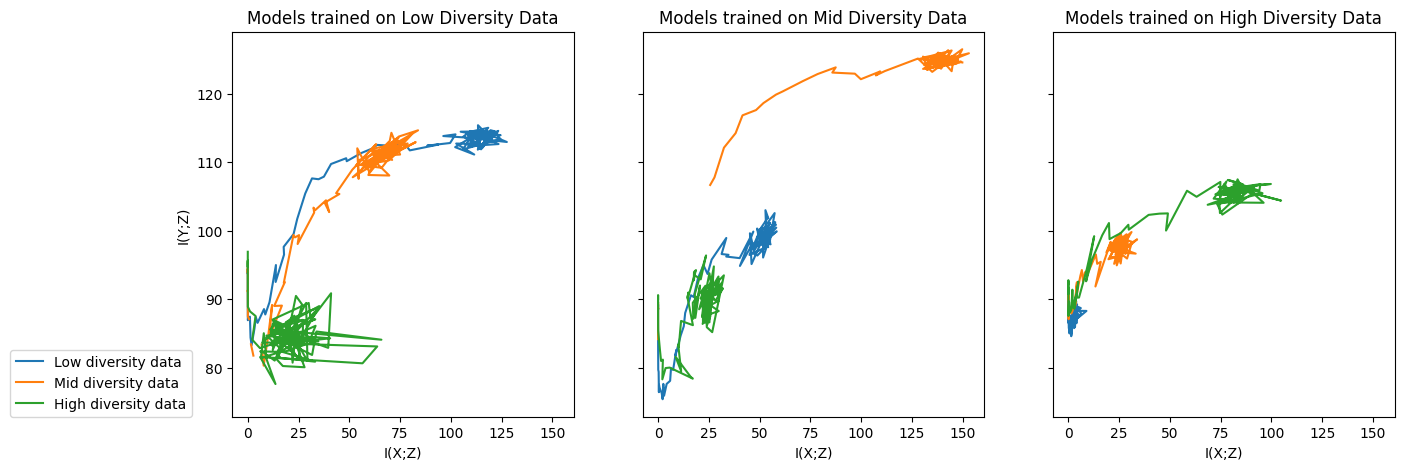

In [202]:
fig, axs = plt.subplots(1, 3, sharex = True, sharey = True)
fig.set_size_inches(15,5)

axs[0].set_ylabel('I(Y;Z)')
axs[0].set_xlabel('I(X;Z)')
axs[1].set_xlabel('I(X;Z)')
axs[2].set_xlabel('I(X;Z)')


axs[0].plot(low_I_XZ_test_low, low_I_YZ_test_low, label = "Low diversity data")
axs[0].plot(low_I_XZ_test_mid, low_I_YZ_test_mid, label = "Mid diversity data")
axs[0].plot(low_I_XZ_test_high, low_I_YZ_test_high, label = "High diversity data")
axs[0].set_title('Models trained on Low Diversity Data')

axs[0].legend(loc=(-.65, 0))

axs[1].plot(mid_I_XZ_test_low, mid_I_YZ_test_low, label = "Low diversity data")
axs[1].plot(mid_I_XZ_test_mid, mid_I_YZ_test_mid, label = "Mid diversity data")
axs[1].plot(mid_I_XZ_test_high, mid_I_YZ_test_high, label = "High diversity data")
axs[1].set_title('Models trained on Mid Diversity Data')

axs[2].plot(high_I_XZ_test_low, high_I_YZ_test_low, label = "Low diversity data")
axs[2].plot(high_I_XZ_test_mid, high_I_YZ_test_mid, label = "Mid diversity data")
axs[2].plot(high_I_XZ_test_high, high_I_YZ_test_high, label = "High diversity data")
axs[2].set_title('Models trained on High Diversity Data')

In [188]:
    with torch.no_grad():
        elbo_loss = 0
        recon_loss = 0
        Y = []
        Yhat = []
        for batch in MidDivDataLoader:
            
            batch = vib(batch)
    
            elbo_loss += vib.prior_loss(batch).sum()
            Y.append(batch['Y'])
            Yhat.append(batch['Yhat'])

        Y = torch.concat(Y, dim = 0)
        Yhat = torch.concat(Yhat, dim = 0)
        yyhat = torch.concat([Y, Yhat], dim = 1)
        Hyyhat = -torch.log(
            torch.linalg.det(
                yyhat.T.cov() + 1e-2 * torch.eye(2*trainLowDivDataset.data_dim)
            )
        )
        Hy = -torch.log(
            torch.linalg.det(
                Y.T.cov()
            )
        )
        Hyhat = -torch.log(
            torch.linalg.det(
                Yhat.T.cov() + 1e-1 * torch.eye(trainLowDivDataset.data_dim)
            )
        )
        iyz = Hyyhat - Hy - Hyhat
        loss = recon_loss + beta * elbo_loss

    low_I_XZ_test_mid.append(elbo_loss / len(MidDivDataset))
    low_I_YZ_test_mid.append(iyz)

In [189]:
-torch.log(torch.linalg.det(yyhat.T.cov()+1e-2 * torch.eye(2*trainLowDivDataset.data_dim)))

tensor(18.0752)

In [190]:
Hy

tensor(-88.6357)

In [191]:
Hyhat

tensor(55.1935)

In [192]:
iyz

tensor(51.5174)